EMT solver main function
2020-2024 Bin Wang, Min Xiong, Deepthi Vaidhynathan, Jonathan Maack
Last modified: 8/15/24

This is the main function for running an EMT simulation case in Docker, 
which does not require setting up environment, and can run in a browser.

In [19]:
import os
import numpy as np
from Lib_BW import *
from psutils import *
from preprocessscript import get_json_pkl
import matplotlib.pyplot as plt
import pandas as pd

workingfolder = '.'
os.chdir(workingfolder)

Then, configure some of the simulation settings:

In [20]:
SimMod = 0  # 0 - Save a snapshot, 1 - run from a snapshot
DSrate = 10 # down sampling rate, i.e. results saved every DSrate sim steps.
systemN = 6 # 1: 2-gen, 2: 9-bus, 3: 39-bus, 4: 179-bus, 5: 240-bus, 6: 2-area
ts = 50e-6  # time step, second
Tlen = 2  # total simulation time length, second

N_row = 1  # haven't tested the mxn layout, so plz don't set N_row/N_col to other nums.
N_col = 1
t_release_f = 0.0
loadmodel_option = 1  # 1-const rlc, 2-const z
netMod = 'lu'
nparts = 2 # number of blocks in BBD form

Initialize EMT simulation:

In [21]:
output_snp_ful = 'sim_snp_S' + str(systemN) + '_' + str(int(ts * 1e6)) + 'u.pkl'
output_snp_1pt = 'sim_snp_S' + str(systemN) + '_' + str(int(ts * 1e6)) + 'u_1pt.pkl'
output_res = 'sim_res_S' + str(systemN) + '_' + str(int(ts * 1e6)) + 'u.pkl'
input_snp = 'sim_snp_S' + str(systemN) + '_' + str(int(ts * 1e6)) + 'u_1pt.pkl'

t0 = time.time()
if SimMod == 0:
    (pfd, ini, dyd, emt) = initialize_emt(workingfolder, systemN, N_row, N_col, ts, Tlen, mode = netMod, nparts=nparts)
else:
    (pfd, ini, dyd, emt) = initialize_from_snp(input_snp, netMod, nparts)

Running simulation for system 6 in layout 1 x 1
power flow loaded
dyn data loaded
dyn data extended
converted to gen ec data
Net initialized
Mac initialized
Exc initialized
Gov initialized
Pss initialized
Merged MacG

     ____                 _____ __  __ _____ 
    |  _ \ __ _ _ __ __ _| ____|  \/  |_   _|
    | |_) / _` | '__/ _` |  _| | |\/| | | |  
    |  __/ (_| | | | (_| | |___| |  | | | |   copyright: NREL
    |_|   \__,_|_|  \__,_|_____|_|  |_| |_|   email: ParaEMT@nrel.gov
    
System initialized
Compiling the code


Configure disturbance settings:

In [22]:
# ctrl step change
emt.t_sc = 100
emt.i_gen_sc = 0
emt.flag_exc_gov = 1  # 0 - exc, 1 - gov
emt.dsp = - 0.02
emt.flag_sc = 1 # default, do not change

# gen trip
emt.t_gentrip = 200
emt.i_gentrip = 1   # 0: 1032 C for WECC 240-bus
emt.flag_gentrip = 1 
emt.flag_reinit = 1

# Bus grounding fault, with line trip
emt.busfault_t = 0.5
emt.fault_bus_idx = 0 
emt.busfault_tlen = 5/60 # 5 cycles
emt.busfault_type = 3 # Check psutils for fault types
emt.busfault_r = [x / 100000 for x in [1, 1, 1, 1, 1, 1]]
emt.fault_tripline = 0 # 1: Enable tripping line
emt.fault_line_idx = 0 #2
emt.bus_del_ind=[]  #bus delete index, do not change
emt.add_line_num=0  # Do not change

Run time domain simulation:

In [23]:
# Before t = t_release_f, PLL freq are fixed at synchronous freq
emt.t_release_f = t_release_f
emt.loadmodel_option = loadmodel_option  # 1-const rlc, 2-const z

# time loop
Nsteps = 0
tn = 0
tsave = 0

# Initialize Bus fault
if emt.busfault_t > 0.0 and emt.busfault_t < emt.Tlen:
    initialize_bus_fault(pfd,ini,dyd,emt, netMod)
cap_line=1

while tn*ts < Tlen:
    tn = tn + 1
    emt.StepChange(dyd, ini, tn)                # configure step change in exc or gov references
    emt.GenTrip(pfd, dyd, ini, tn, netMod)      # configure generation trip

    if tn*ts < emt.busfault_t:
        emt.net_coe = ini.Init_net_coe0
        # emt.Ginv = ini.Init_net_G0 #TODO: Check whether this is correct? No inverse at all
        if netMod == 'inv':
            emt.Ginv=ini.Init_net_G0_inv
        elif netMod == 'lu':
            emt.Glu = ini.Init_net_G0_lu
        emt.brch_range = np.array([0,len(emt.net_coe)]).reshape(2,1) # 
    elif (tn*ts >= emt.busfault_t) and (tn*ts < emt.busfault_t+emt.busfault_tlen):
        # emt.Ginv = ini.Init_net_G1
        emt.net_coe = ini.Init_net_coe1
        if netMod == 'inv':
            emt.Ginv=ini.Init_net_G1_inv
        elif netMod == 'lu':
            emt.Glu = ini.Init_net_G1_lu
        emt.brch_range = np.array([0,len(emt.net_coe)]).reshape(2,1) # Min, consider new lines under fault
        if cap_line==1: # do it only once
            emt.brch_Ipre= np.append(emt.brch_Ipre,np.zeros(emt.add_line_num)) # added line, Ipre=0
            emt.brch_Ihis= np.append(emt.brch_Ihis,np.zeros(emt.add_line_num))
            cap_line=0
    else:
        emt.net_coe = ini.Init_net_coe2
        if netMod == 'inv':
            emt.Ginv = ini.Init_net_G2_inv
        elif netMod == 'lu':
            emt.Glu = ini.Init_net_G2_lu
        emt.brch_range = np.array([0,len(emt.net_coe)]).reshape(2,1) # Min
        if cap_line==0: # do it only once
            if emt.fault_tripline == 0:
                emt.brch_Ipre=emt.brch_Ipre[:-emt.add_line_num]
                emt.brch_Ihis=emt.brch_Ihis[:-emt.add_line_num] # delete those added lines
            if emt.fault_tripline == 1:  
                emt.brch_Ipre=emt.brch_Ipre[:-emt.add_line_num]
                emt.brch_Ihis=emt.brch_Ihis[:-emt.add_line_num] # delete those added lines
                emt.brch_Ipre=np.delete(emt.brch_Ipre, emt.bus_del_ind, 0) # 0 delete row
                emt.brch_Ihis=np.delete(emt.brch_Ihis, emt.bus_del_ind, 0) # Delete those related to tripped lines, to match the index in update Ihis                 
            cap_line=1
                
    emt.predictX(pfd, dyd, emt.ts)
    emt.Igs = emt.Igs * 0
    emt.updateIg(pfd, dyd, ini)
    emt.Igi = emt.Igi * 0
    emt.Iibr = emt.Iibr * 0
    emt.updateIibr(pfd, dyd, ini)
    if emt.loadmodel_option == 1:
        pass
    else:
        emt.Il = emt.Il * 0
        emt.updateIl(pfd, dyd, tn)   # update current injection from load
    emt.solveV(ini)
    emt.BusMea(pfd, dyd, tn)     # bus measurement
    emt.updateX(pfd, dyd, ini, tn)
    emt.updateXibr(pfd, dyd, ini, ts)
    if emt.loadmodel_option == 1:
        pass
    else:
        emt.updateXl(pfd, dyd, tn)
    emt.x_pred = {0:emt.x_pred[1],1:emt.x_pred[2],2:emt.x_pv_1}

    if np.mod(tn, DSrate) == 0:
        tsave = tsave + 1
        # save states
        emt.t.append(tn * ts)
        print("%.4f" % emt.t[-1])
        emt.x[tsave] = emt.x_pv_1.copy()
        if len(pfd.ibr_bus) > 0:
            emt.x_ibr[tsave] = emt.x_ibr_pv_1.copy()
        if len(pfd.bus_num) > 0:
            emt.x_bus[tsave] = emt.x_bus_pv_1.copy()
        if len(pfd.load_bus) > 0:
            emt.x_load[tsave] = emt.x_load_pv_1.copy()
        emt.v[tsave] = emt.Vsol.copy()
        term=emt.brch_Ipre.copy()
        term2=9*len(pfd.line_from)
        term3=9*len(pfd.line_from)+3*len(pfd.xfmr_from) # save only line RL current and transformer current
        emt.i_branch[tsave]=np.concatenate((term[9*len(pfd.line_from):term3:3], term[0:term2:9],  \
                                                        term[9*len(pfd.line_from)+1:term3:3],term[1:term2:9],  \
                                                        term[9*len(pfd.line_from)+2:term3:3], term[2:term2:9]))   
    # re-init
    if ((emt.flag_gentrip == 0) & (emt.flag_reinit == 1) or
        (tn*ts >= emt.busfault_t and (tn - 1)*ts < emt.busfault_t) or
        (tn*ts >= emt.busfault_t + emt.busfault_tlen and (tn - 1)*ts < emt.busfault_t + emt.busfault_tlen)
        ):
        emt.Re_Init(pfd, dyd, ini)
    else:
        emt.updateIhis(ini)
    Nsteps += 1

0.0005
0.0010
0.0015
0.0020
0.0025
0.0030
0.0035
0.0040
0.0045
0.0050
0.0055
0.0060
0.0065
0.0070
0.0075
0.0080
0.0085
0.0090
0.0095
0.0100
0.0105
0.0110
0.0115
0.0120
0.0125
0.0130
0.0135
0.0140
0.0145
0.0150
0.0155
0.0160
0.0165
0.0170
0.0175
0.0180
0.0185
0.0190
0.0195
0.0200
0.0205
0.0210
0.0215
0.0220
0.0225
0.0230
0.0235
0.0240
0.0245
0.0250
0.0255
0.0260
0.0265
0.0270
0.0275
0.0280
0.0285
0.0290
0.0295
0.0300
0.0305
0.0310
0.0315
0.0320
0.0325
0.0330
0.0335
0.0340
0.0345
0.0350
0.0355
0.0360
0.0365
0.0370
0.0375
0.0380
0.0385
0.0390
0.0395
0.0400
0.0405
0.0410
0.0415
0.0420
0.0425
0.0430
0.0435
0.0440
0.0445
0.0450
0.0455
0.0460
0.0465
0.0470
0.0475
0.0480
0.0485
0.0490
0.0495
0.0500
0.0505
0.0510
0.0515
0.0520
0.0525
0.0530
0.0535
0.0540
0.0545
0.0550
0.0555
0.0560
0.0565
0.0570
0.0575
0.0580
0.0585
0.0590
0.0595
0.0600
0.0605
0.0610
0.0615
0.0620
0.0625
0.0630
0.0635
0.0640
0.0645
0.0650
0.0655
0.0660
0.0665
0.0670
0.0675
0.0680
0.0685
0.0690
0.0695
0.0700
0.0705
0.0710
0.0715

Then, plot simulation results:

Example 1: plot generator rotor angle and rotor frequency 

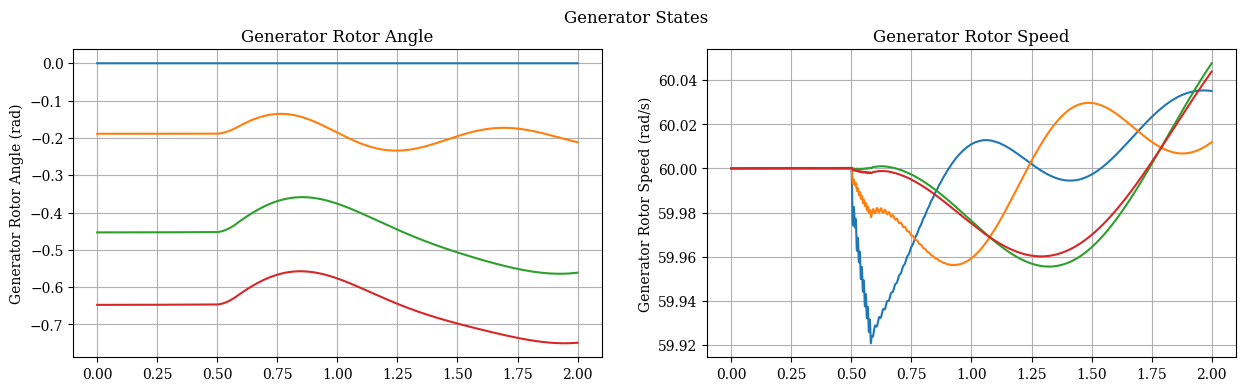

In [24]:
plt.rcParams["font.family"] = "serif"

xaxis = np.arange(0, Tlen+ts, DSrate*ts)
Genrou=np.matrix(list(emt.x.values()))
# Genrou=np.matrix(emt.x)
# plt.rc('font', family='Times New Roman', size=14)
fig, axs = plt.subplots(1,2, sharex=False, sharey=False, figsize=(15, 4))
fig.suptitle("Generator States")

# No 1, synchronous generator Delta angle
axs[0].plot(xaxis, Genrou[:,0:dyd.gen_genrou_odr*len(pfd.gen_bus):dyd.gen_genrou_odr]-Genrou[:,0], linestyle="-")
axs[0].set(ylabel="Generator Rotor Angle (rad)")
axs[0].set_title("Generator Rotor Angle") 
axs[0].grid(True)

# No 2, synchronous generator rotor frequency
axs[1].plot(xaxis, Genrou[:,1:dyd.gen_genrou_odr*len(pfd.gen_bus):dyd.gen_genrou_odr]/2/np.pi, linestyle="-")
axs[1].set(ylabel="Generator Rotor Speed (rad/s)")
axs[1].set_title("Generator Rotor Speed") 
# axs[1].set_ylim(59, 60.05)
axs[1].grid(True)

plt.savefig("Figure_ParaEMT_Generator.png", format="png")  
plt.draw()
plt.show() 

Example 2: plot three phase voltage at Bus 1 and Bus 2

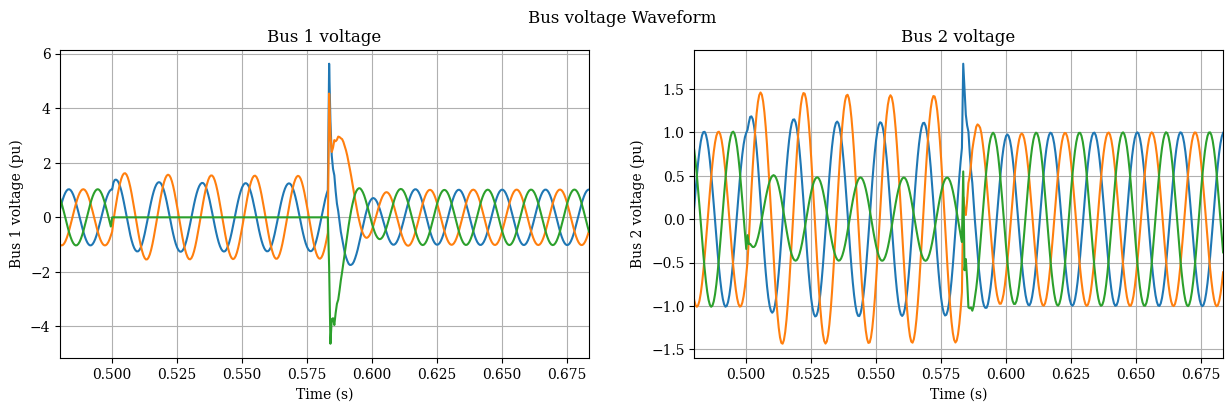

In [25]:
V_network=np.matrix(list(emt.v.values()))

# plt.rc('font', family='Times New Roman', size=14)
fig, axs = plt.subplots(1,2, sharex=False, sharey=False, figsize=(15, 4))
fig.suptitle("Bus voltage Waveform")
# No 1, Voltage waveform at bus1
Bus1=0
axs[0].plot(xaxis, V_network[:,Bus1:3*len(pfd.bus_num):len(pfd.bus_num)], linestyle="-")
axs[0].set(ylabel=f"Bus {Bus1+1} voltage (pu)")
axs[0].set_title(f"Bus {Bus1+1} voltage")
axs[0].grid(True)
    
# No 2, Voltage waveform at bus 2
Bus2=Bus1+1
axs[1].plot(xaxis, V_network[:,Bus2:3*len(pfd.bus_num):len(pfd.bus_num)], linestyle="-")
axs[1].set(ylabel=f"Bus {Bus2+1} voltage (pu)")
axs[1].set_title(f"Bus {Bus2+1} voltage")
axs[1].grid(True)

for ax in axs.flat:
    ax.set_xlim([emt.busfault_t-0.02, emt.busfault_t+emt.busfault_tlen+0.1]) 
    ax.set_xlabel("Time (s)")
plt.savefig("Figure_ParaEMT_EPRI_3phaseV.png", format="png")  
plt.draw()
plt.show() 

Then, save simulation results as .csv files

In [26]:
df_v = pd.DataFrame(emt.v).T
df_v.to_csv("paraemt_v.csv")

df_ibran = pd.DataFrame(emt.i_branch).T
df_ibran.to_csv("paraemt_ibranch.csv")

Cbus = []
for i in range(len(pfd.bus_num)):
    Cbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + 'ze')
    Cbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + 'de')
    Cbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + 'we')
    Cbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + 'vt')
    Cbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + 'vtm')
    Cbus.append(str(pfd.bus_num[i]) + '_' + pfd.bus_name[i] + '_' + 'dvtm')

if len(pfd.bus_num) > 0:
    dfbus = pd.DataFrame(emt.x_bus).T
    dfbus.to_csv("paraemt_bus.csv", header=Cbus, index=False)

dfx = pd.DataFrame(emt.x).T
dfx.to_csv("paraemt_x.csv")

Cibr = []
for i in range(dyd.ibr_n):
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 's0')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 's1')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 's2')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 'Vmp')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 'Vap')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 'i1')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 'i2')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_regca_' + 'ip2rr')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 's0')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 's1')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 's2')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 's3')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 's4')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 's5')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 'Ipcmd')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 'Iqcmd')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 'Pref')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 'Qref')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 'q2vPI')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_reecb_' + 'v2iPI')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's0')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's1')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's2')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's3')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's4')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's5')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 's6')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Vref')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Qref')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Freq_ref')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Plant_ref')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'LineMW')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'LineMvar')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'LineMVA')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'QVdbout')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'fdbout')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'vq2qPI')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'p2pPI')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Vf')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Pe')
    Cibr.append(str(pfd.ibr_bus[i]) + '_' + pfd.ibr_id[i] + '_repca_' + 'Qe')

if len(pfd.ibr_bus)>0:
    dfibr = pd.DataFrame(emt.x_ibr).T
    dfibr.to_csv("paraemt_ibr.csv", header=Cibr, index=False)

Cload = []
for i in range(len(pfd.load_bus)):
    Cload.append(str(pfd.load_bus[i]) + '_' + pfd.load_id[i] + '_' + 'ZL_mag')
    Cload.append(str(pfd.load_bus[i]) + '_' + pfd.load_id[i] + '_' + 'ZL_ang')
    Cload.append(str(pfd.load_bus[i]) + '_' + pfd.load_id[i] + '_' + 'PL')
    Cload.append(str(pfd.load_bus[i]) + '_' + pfd.load_id[i] + '_' + 'QL')
if len(pfd.load_bus)>0:
    dfLd = pd.DataFrame(emt.x_load).T
    dfLd.to_csv("paraemt_load.csv", header=Cload, index=False)

Fianlly, save simulation results as .pkl files

In [27]:
emt.dump_res(pfd, dyd, ini, SimMod, output_snp_ful, output_snp_1pt, output_res)